In [ ]:
### mount drive for accessing data and saving models
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
### import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [ ]:
#### here we are using only the spectrograms so just use the path of the spectrogram path
data_dir = pathlib.Path("/content/gdrive/MyDrive/music_data/images/spect/")

In [ ]:
### gen refers to the generated files, org refers to the real music ie from the adl dataset
gen = list(data_dir.glob('gen_wav/*'))
org = list(data_dir.glob('adl_wav/*'))

In [ ]:
batch_size = 8
img_height = 720
img_width = 720

In [ ]:
from keras.applications.vgg16 import preprocess_input

In [ ]:
### split into train and validation data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 398 files belonging to 2 classes.
Using 279 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 398 files belonging to 2 classes.
Using 119 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['adl', 'gen']


In [ ]:
for image_batch, labels_batch in train_ds:
  #image_batch = preprocess_input(image_batch)
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 720, 720, 3)
(8,)


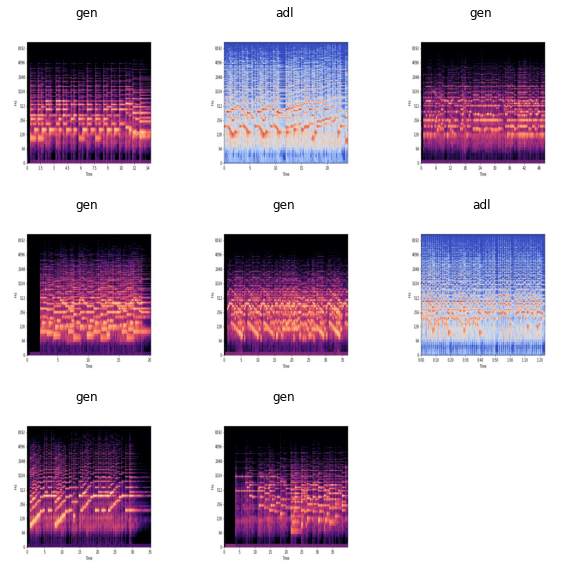

In [ ]:
#### Visualise samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#### BASE TRAINED MODEL
base_model = tf.keras.applications.VGG19(input_shape=(720, 720, 3), include_top=False)
base_model.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 22, 22, 512)


In [ ]:
### Transfer learning MODEL
base_model = tf.keras.applications.VGG19(input_shape=(720, 720, 3), include_top=False)
base_model.trainable = False
num_classes = 2
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  base_model,
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(2048, activation='relu'),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [ ]:
#### train the model
epochs=10
history_original = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
35/35 [==============================] - 15s 397ms/step - loss: 481.4028 - accuracy: 0.4588 - val_loss: 0.4896 - val_accuracy: 0.4874
Epoch 2/10
35/35 [==============================] - 14s 392ms/step - loss: 0.7437 - accuracy: 0.5233 - val_loss: 0.1684 - val_accuracy: 0.6471
Epoch 3/10
35/35 [==============================] - 14s 393ms/step - loss: 0.5330 - accuracy: 0.5269 - val_loss: 1.3807 - val_accuracy: 0.4790
Epoch 4/10
35/35 [==============================] - 14s 392ms/step - loss: 0.7242 - accuracy: 0.5484 - val_loss: 0.5377 - val_accuracy: 0.5210
Epoch 5/10
35/35 [==============================] - 14s 394ms/step - loss: 0.9716 - accuracy: 0.5018 - val_loss: 2.6785 - val_accuracy: 0.5210
Epoch 6/10
35/35 [==============================] - 14s 395ms/step - loss: 1.5512 - accuracy: 0.5269 - val_loss: 0.2533 - val_accuracy: 0.5210
Epoch 7/10
35/35 [==============================] - 14s 395ms/step - loss: 0.5707 - accuracy: 0.5054 - val_loss: 1.7065 - val_accuracy: 0.52

In [ ]:
#model.save("/content/gdrive/MyDrive/music_data/models/model_transfer_5_10_epochs.h5")

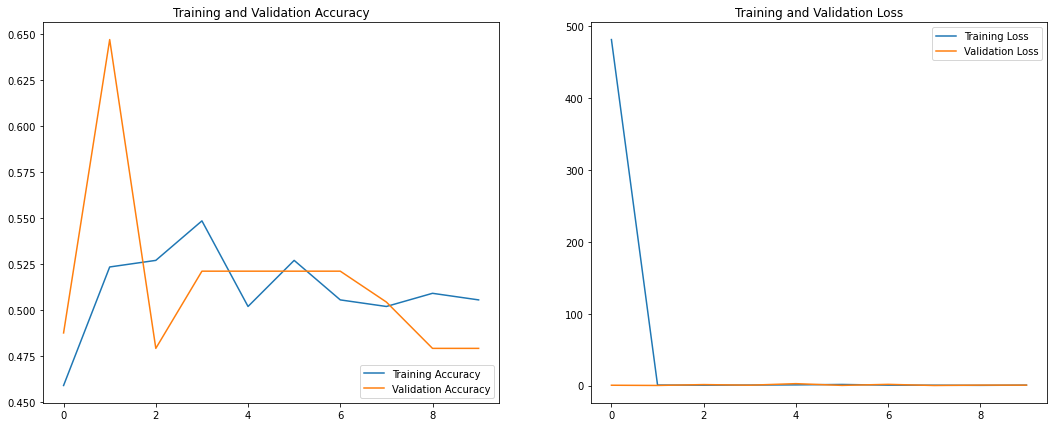

In [ ]:
#### VISUALIZE PLOTS
acc = history_original.history['accuracy']
val_acc = history_original.history['val_accuracy']

loss = history_original.history['loss']
val_loss = history_original.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig("/content/gdrive/MyDrive/music_data/plots/model3_transfer_10_epochs_acc.jpg")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/gdrive/MyDrive/music_data/plots/model3_transfer_10_epochs_loss.jpg")
plt.show()